In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
DATA_ROOT = '/content/drive/MyDrive/dataset'
OUTPUT_ROOT = '/content/drive/MyDrive/dataset_new'

all_files = []
all_labels = []

print(f"Scanning files in: {DATA_ROOT}")
for label_name in os.listdir(DATA_ROOT):
    class_dir = os.path.join(DATA_ROOT, label_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg')):
                all_files.append(os.path.join(class_dir, filename))
                all_labels.append(label_name)

if not all_files:
    print("Error: No document images found in the specified directory structure.")
    exit()

df = pd.DataFrame({'filepath': all_files, 'label': all_labels})
print(f"Total documents found: {len(df)}")


Scanning files in: /content/drive/MyDrive/dataset
Error: No document images found in the specified directory structure.
Total documents found: 0


In [ ]:
df.head(10)

NameError: name 'df' is not defined

In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,
    random_state=42,
    shuffle=True,
    stratify=df['label']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=temp_df['label']
)

print(f"\n--- Split Summary ---")
print(f"Training set size: {len(train_df)} ({len(train_df) / len(df) * 100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df) / len(df) * 100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df) / len(df) * 100:.1f}%)")

In [ ]:
split_dfs = {'train': train_df, 'val': val_df, 'test': test_df}

if os.path.exists(OUTPUT_ROOT):
    shutil.rmtree(OUTPUT_ROOT)

for split_name, split_df in split_dfs.items():
    print(f"\nCreating {split_name} directories and moving files...")

    split_dir = os.path.join(OUTPUT_ROOT, split_name)
    os.makedirs(split_dir, exist_ok=True)

    for index, row in split_df.iterrows():
        label = row['label']

        class_output_dir = os.path.join(split_dir, label)
        os.makedirs(class_output_dir, exist_ok=True)

        src_path = row['filepath']
        dest_filename = os.path.basename(src_path)
        dest_path = os.path.join(class_output_dir, dest_filename)

        shutil.move(src_path, dest_path)

print(f"Data has been split and moved to the '{OUTPUT_ROOT}' directory.")

In [ ]:
dataset_path = '/content/drive/MyDrive/dataset'
print("📁 Dataset structure:")
for item in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, item)):
        print(f"📂 {item}")
for item in os.listdir(dataset_path):
    sample_folder = f'/content/drive/MyDrive/dataset/{item}'
    if os.path.exists(sample_folder):
        print(f"\n📊 Sample folder '{sample_folder}': {len(os.listdir(sample_folder))} images")

📁 Dataset structure:
📂 resume
📂 news_article
📂 invoice
📂 email
📂 letter
📂 form

📊 Sample folder '/content/drive/MyDrive/dataset/resume': 0 images

📊 Sample folder '/content/drive/MyDrive/dataset/news_article': 0 images

📊 Sample folder '/content/drive/MyDrive/dataset/invoice': 0 images

📊 Sample folder '/content/drive/MyDrive/dataset/email': 0 images

📊 Sample folder '/content/drive/MyDrive/dataset/letter': 0 images

📊 Sample folder '/content/drive/MyDrive/dataset/form': 0 images


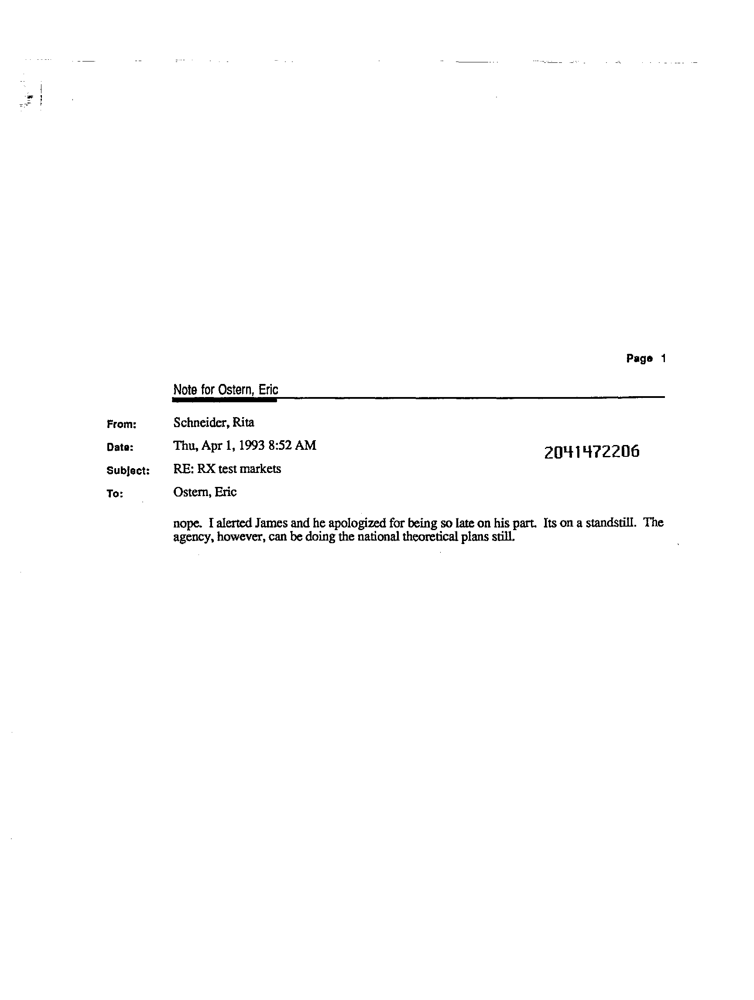

In [ ]:
from PIL import Image

image = Image.open("/content/drive/MyDrive/dataset_new/test/email/2041472206.tif")
image = image.convert("RGB")
image

In [ ]:
# Install tesseract-ocr
!sudo apt install tesseract-ocr
!pip install pytesseract pillow tqdm torch

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'Page 1 Note for Ostern, Eric — From: Schneider, Rita ate: Thu, Apr 1, 1993 8:52 AM 2041472206 Subject: RE: RX test markets To: Ostem, Eric nope. [alerted James and he apologized for being so late on his part. Its on a standstill. The agency, however, can be doing the national theoretical plans still.'

In [ ]:
from datasets import Dataset, Features, Value
from transformers import AutoProcessor
from tqdm import tqdm
import torch

In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
GPU Available: False


In [ ]:
if torch.cuda.is_available():
    print("🎉 GPU is available and will be used for training!")
    print(f"GPU Device: {torch.cuda.get_device_name()}")
else:
    print("❌ No GPU detected")

❌ No GPU detected


In [ ]:
DATA_ROOT = '/content/drive/MyDrive/dataset_new'
MODEL_NAME = "microsoft/layoutlmv2-base-uncased"
MAX_SEQ_LENGTH = 512

processor = AutoProcessor.from_pretrained(MODEL_NAME, apply_ocr=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def create_dataframe_for_split(split_name):
    print(f"Gathering file paths for the {split_name} split...")
    split_path = os.path.join(DATA_ROOT, split_name)
    data = []

    for label_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, label_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg')):
                    data.append({
                        'image_path': os.path.join(class_dir, filename),
                        'label': label_name,
                    })

    return data

train_data = create_dataframe_for_split('train')
val_data = create_dataframe_for_split('val')
test_data = create_dataframe_for_split('test')

raw_dataset = {
    'train': Dataset.from_list(train_data),
    'val': Dataset.from_list(val_data),
    'test': Dataset.from_list(test_data)
}

raw_dataset['train'] = raw_dataset['train'].shuffle(seed=42).select(range(1800))

raw_dataset['val'] = raw_dataset['val'].shuffle(seed=42).select(range(600))

raw_dataset['test'] = raw_dataset['test'].shuffle(seed=42).select(range(600))

Gathering file paths for the train split...
Gathering file paths for the val split...
Gathering file paths for the test split...


In [ ]:
print("Num GPUs Available: ", torch.cuda.device_count())

Num GPUs Available:  0


In [ ]:
train_data

[{'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028718888.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028726390.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028715946_2028715947.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028715872.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028721085.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028741327_2028741328.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028742124_2028742125.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028743223_2028743224.tif',
  'label': 'invoice'},
 {'image_path': '/content/drive/MyDrive/dataset_new/train/invoice/2028716668.tif',
  'label': 'invoice'},
 {

In [ ]:
raw_dataset

{'train': Dataset({
     features: ['image_path', 'label'],
     num_rows: 1800
 }),
 'val': Dataset({
     features: ['image_path', 'label'],
     num_rows: 600
 }),
 'test': Dataset({
     features: ['image_path', 'label'],
     num_rows: 600
 })}

In [ ]:
raw_dataset['train']

Dataset({
    features: ['image_path', 'label'],
    num_rows: 1800
})

In [ ]:
label_list = sorted(list(set(raw_dataset['train']['label'])))
label_to_int = {label: i for i, label in enumerate(label_list)}
num_labels = len(label_list)
print(f"\nDetected Labels ({num_labels}): {label_list}")

def map_label_to_int(examples):
    examples['labels'] = [label_to_int[label] for label in examples['label']]
    return examples

raw_dataset = {
    split: raw_dataset[split].map(map_label_to_int, batched=True)
    for split in raw_dataset
}


Detected Labels (6): ['email', 'form', 'invoice', 'letter', 'news_article', 'resume']


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
def preprocess_data(examples):

    images = [Image.open(path).convert("RGB") for path in examples['image_path']]

    encoding = processor(
        images=images,
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors="pt"
    )

    encoding['labels'] = torch.tensor(examples['labels'], dtype=torch.long)

    return encoding

In [ ]:
single_example = raw_dataset['train'][0:1]

print("Testing single-example preprocessing...")

try:
    test_output = preprocess_data(single_example)
    print("✅ Single example processed successfully.")

    print(f"Input IDs shape: {test_output['input_ids'].shape}")

except Exception as e:
    print(f"❌ ERROR: Failed to process single example. Cause: {e}")


Testing single-example preprocessing...
✅ Single example processed successfully.
Input IDs shape: torch.Size([1, 512])


In [ ]:

print("\nApplying LayoutLMv2 Processor (OCR, Fusion, and Tokenization)")
encoded_dataset = {}
for split_name, ds in raw_dataset.items():
    encoded_dataset[split_name] = ds.map(
        preprocess_data,
        batched=True,
        batch_size=32,
        remove_columns=ds.column_names,
        desc=f"Preprocessing {split_name} Split"
    )
    encoded_dataset[split_name].set_format(type="torch")

print("Encoded Dataset Structure (Example for Training Split):")
print(encoded_dataset['train'])
print(f"Number of classes (for model config): {num_labels}")


Applying LayoutLMv2 Processor (OCR, Fusion, and Tokenization)


Preprocessing train Split:   0%|          | 0/1800 [00:00<?, ? examples/s]

Preprocessing val Split:   0%|          | 0/600 [00:00<?, ? examples/s]

Preprocessing test Split:   0%|          | 0/600 [00:00<?, ? examples/s]

Encoded Dataset Structure (Example for Training Split):
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'],
    num_rows: 1800
})
Number of classes (for model config): 6


In [ ]:

# path to your folder in Drive
path = "/content/drive/MyDrive/encoded_data"

# make directory
os.makedirs(path, exist_ok=True)

print("Folder created at:", path)


Folder created at: /content/drive/MyDrive/encoded_data


In [ ]:
# Assuming 'encoded_dataset' is the dictionary containing your splits (train, validation, etc.)

SAVE_PATH = "/content/drive/MyDrive/encoded_data"

# Save each split in the dictionary
for split_name, ds in encoded_dataset.items():
    print(f"Saving {split_name} split to disk...")
    # This creates a folder like './layoutlmv2_processed_data/train'
    ds.save_to_disk(f"{SAVE_PATH}/{split_name}")

print("Dataset successfully saved!")

Saving train split to disk...


Saving the dataset (0/3 shards):   0%|          | 0/1800 [00:00<?, ? examples/s]

Saving val split to disk...


Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

Saving test split to disk...


Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

Dataset successfully saved!


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/raw_dataset"

# Create directory
os.makedirs(SAVE_PATH, exist_ok=True)

# Save each split
for split_name, ds in raw_dataset.items():
    print(f"Saving {split_name} split...")
    ds.save_to_disk(f"{SAVE_PATH}/{split_name}")

print("✅ Raw dataset saved successfully!")

Saving train split...


Saving the dataset (0/1 shards):   0%|          | 0/1800 [00:00<?, ? examples/s]

Saving val split...


Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

Saving test split...


Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

✅ Raw dataset saved successfully!


In [ ]:
processor.save_pretrained("/content/drive/MyDrive/documind-model")

[]

In [ ]:
from datasets import load_from_disk

# Reload your processed data
encoded_dataset = {
    'train': load_from_disk("/content/drive/MyDrive/encoded_data/train"),
    'val': load_from_disk("/content/drive/MyDrive/encoded_data/val"),
    'test': load_from_disk("/content/drive/MyDrive/encoded_data/test")
}

print("✅ Encoded dataset reloaded!")

✅ Encoded dataset reloaded!


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-515kruyi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-515kruyi
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done


In [ ]:
from transformers import LayoutLMv2ForSequenceClassification

# Initialize model for classification
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    num_labels=num_labels  # Your 6 document classes
)

print("✅ Model initialized!")

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model initialized!


In [ ]:
# Convert all splits to PyTorch format
for split_name in encoded_dataset:
    encoded_dataset[split_name].set_format(type='torch')

print("✅ Dataset converted to PyTorch format")

✅ Dataset converted to PyTorch format


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./documind-results",
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Reduced for memory
    per_device_eval_batch_size=4,
    learning_rate=1e-4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,  # Important!
    dataloader_pin_memory=False,  # Important for Colab
    report_to=None,  # Disable wandb if not needed
)

print("✅ Training arguments configured")

✅ Training arguments configured


In [ ]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
)

# START TRAINING! 🎯
print("🚀 Starting training...")
trainer.train()

🚀 Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sahil-20222044 (sahil-20222044-motilal-nehru-national-institute-of-techn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Test on validation set
eval_results = trainer.evaluate()
print(f"📊 Validation Results: {eval_results}")

# Test on unseen test set
test_results = trainer.evaluate(encoded_dataset["test"])
print(f"📊 Test Results: {test_results}")